In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
from astropy.io import fits
import datetime
from astropy import units as u
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import time

In [2]:
from some_func import cart2spheric, spheric2cart, spheric_coordinates_rotate, hor2pix_keo, bright_relay_keo

In [3]:
img_num=2408
# img_num=2507

In [4]:
pic_save_name='/home/ashindin/temp/' + str(img_num) + '.png'

In [5]:
fit_filename='../DATA/02_KEO/140824/20140824_' + str(img_num) + '.fit'
dark_filename='../DATA/02_KEO/140824/dark/keo_aug24_dark_median.fit'
BS6300_catalog_filename='Haritonov_6300BS_catalog.npz'

In [6]:
# Координаты расположения KEO
lat_keo=55.9305361 # ШИРОТА
lon_keo=48.7444861 # ДОЛГОТА
h_keo=91.0
KEO_site=EarthLocation(lat=lat_keo*u.deg, lon=lon_keo*u.deg, height=h_keo*u.m)

# Ориентация KEO - 24 августа
az0_keo = 6.0729592128071603;
alt0_keo = 1.5428754318596944;
a_keo = (   1.1260974991748651,   -0.0048692544335450,    0.0004054871474967)
b_keo = (   1.3414326667154699,   -0.0003973836009369,   -0.0048666234384367)
c_keo = ( 252.5023732028608379, -203.9735999213842206,  -16.9930115762693461)
d_keo = ( 255.0212588337721229,   16.6581624996323754, -204.0858265523006594)

In [7]:
npzfile=np.load(BS6300_catalog_filename)
CAT_FIELDS=npzfile['CAT_FIELDS']
CAT_6300BS=npzfile['CAT_6300BS']
CAT_SPTYPE=npzfile['CAT_SPTYPE']
print(CAT_FIELDS)

['HARITONOV_ID' 'BS_ID' 'RA (icrs, deg)' 'DEC (icrs, deg)' 'MAG_V'
 '6300 Flux (erg/(sm^2 * s *  sm))']


In [8]:
fid_fit=fits.open(fit_filename);
date_obs_str=fid_fit[0].header["DATE-OBS"]
img=fid_fit[0].data;
img=img.astype('d')
fid_fit.close()
dark=fits.getdata(dark_filename);
dark.astype('d')
img=img-dark
date_obs=datetime.datetime.strptime(date_obs_str,"%Y-%m-%dT%H:%M:%S")+datetime.timedelta(seconds=15)
print(date_obs)

2014-08-24 19:52:10


In [9]:
BS_coord=SkyCoord(CAT_6300BS[:,2], CAT_6300BS[:,3], frame='icrs', unit='deg');

altaz=BS_coord.transform_to(AltAz(obstime=date_obs, location=KEO_site,temperature=15*u.deg_C,pressure=1013*u.hPa,
                                       relative_humidity=0.5,obswl=630.0*u.nm))
BS_AzAlt=np.zeros((np.size(CAT_6300BS,0),2))
BS_AzAlt[:,0]=altaz.az.degree
BS_AzAlt[:,1]=altaz.alt.degree

In [10]:
print(BS_AzAlt[28,0],BS_AzAlt[28,1])

92.5910864862 46.5220644502


In [11]:
BS_xy=np.zeros((np.size(CAT_6300BS,0),2))
BS_xy[:,0], BS_xy[:,1] = hor2pix_keo (BS_AzAlt[:,0]*np.pi/180,BS_AzAlt[:,1]*np.pi/180, az0_keo, alt0_keo, c_keo, d_keo)

In [12]:
# Catalog filtration
filt_mask=np.zeros(np.size(CAT_6300BS,0),dtype=bool)
for i in range(0,np.size(CAT_6300BS,0)):
    if BS_AzAlt[i,1]>=44.0 and BS_AzAlt[i,1]<=62.0:
#     if BS_AzAlt[i,1]>=62.0: #and BS_AzAlt[i,1]<=82.0:
        if BS_xy[i,0]>=1 and BS_xy[i,0]<=511:
            if BS_xy[i,1]>=1 and BS_xy[i,1]<=511:
                filt_mask[i]=True
BS_AzAlt_filt=BS_AzAlt[filt_mask,:]
BS_xy_filt=BS_xy[filt_mask,:]
CAT_6300BS_filt=CAT_6300BS[filt_mask,:]
CAT_SPTYPE_filt=CAT_SPTYPE[filt_mask]

In [13]:
np.size(BS_xy_filt,0)

90

In [14]:
CAT_6300BS_filt[:,0]

array([   1.,    5.,    6.,   12.,   13.,   15.,   17.,   18.,   19.,
         22.,   23.,   28.,   29.,   30.,   36.,   37.,   40.,   47.,
         48.,   58.,   66.,   89.,   90.,   97.,  132.,  259.,  280.,
        328.,  336.,  349.,  355.,  360.,  365.,  369.,  370.,  377.,
        379.,  387.,  388.,  390.,  392.,  393.,  399.,  401.,  402.,
        403.,  406.,  409.,  410.,  412.,  419.,  420.,  424.,  425.,
        426.,  431.,  438.,  442.,  443.,  447.,  455.,  456.,  457.,
        458.,  460.,  462.,  469.,  472.,  473.,  476.,  478.,  486.,
        487.,  497.,  498.,  507.,  508.,  514.,  525.,  526.,  528.,
        530.,  535.,  537.,  548.,  549.,  552.,  553.,  564.,  565.])

In [15]:
img_red_st_int=np.zeros(np.size(BS_xy_filt,0))
img_red_st_num=np.zeros(np.size(BS_xy_filt,0))
BS_adc_filt=np.zeros(np.size(BS_xy_filt,0))
area_rad=2
for j in range(np.size(BS_xy_filt,0)):    
    st_x=BS_xy_filt[j,0]
    st_y=BS_xy_filt[j,1]
    area=img[int(st_y)-area_rad:int(st_y)+area_rad+1, int(st_x)-area_rad:int(st_x)+area_rad+1]

    sum_temp=0.0
    num=0
    med=np.median(area)
    for i in range(len(area.flat)):
        if area.flat[i]>=1.3*med:
            num+=1
            sum_temp+=area.flat[i]-med
    img_red_st_int[j]=sum_temp
    img_red_st_num[j]=num
    if num>0:
        BS_adc_filt[j]=sum_temp/num

In [16]:
print(img_red_st_num)

[ 4.  3.  1.  0.  1.  1.  3.  1.  1.  2.  2.  1.  5.  2.  3.  3.  1.  1.
  2.  2.  2.  1.  2.  0.  0.  0.  1.  4.  4.  1.  4.  4.  4.  0.  1.  0.
  2.  2.  1.  3.  2.  1.  6.  1.  1.  1.  1.  0.  0.  0.  2.  1.  0.  1.
  0.  2.  1.  2.  0.  1.  2.  2.  0.  1.  0.  2.  1.  0.  1.  0.  1.  1.
  1.  1.  2.  0.  1.  1.  1.  2.  2.  2.  5.  3.  0.  0.  1.  0.  1.  1.]


In [17]:
BS_relay=np.zeros(np.size(BS_xy_filt,0))
R_adc_coef=np.zeros(np.size(BS_xy_filt,0))
for i in range(np.size(BS_xy_filt,0)):
     if img_red_st_num[i]>3:
            BS_relay[i]=bright_relay_keo(CAT_6300BS_filt[i,5],img_red_st_num[i])
            if BS_adc_filt[i]>0 and BS_relay[i]>100:
                R_adc_coef[i]=BS_relay[i]/BS_adc_filt[i]

print(BS_relay)

In [18]:
print(R_adc_coef[R_adc_coef.nonzero()])
R_median=np.median(R_adc_coef[R_adc_coef.nonzero()])
print(R_median)

[ 0.40720453  0.39803476  0.32043762  0.25125739  0.29251469  0.3218874
  0.37066402]
0.321887399165


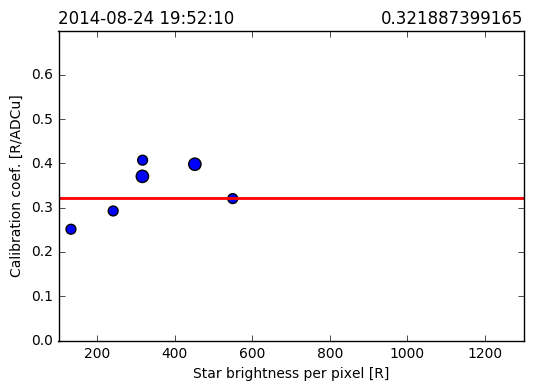

In [19]:
fig,ax = plt.subplots()
plt.plot([0, 5000], [R_median, R_median], c='r', lw=2)
plt.scatter(BS_relay,R_adc_coef,s=np.pi*(img_red_st_num)**2)
plt.ylabel('Calibration coef. [R/ADCu]')
plt.xlabel('Star brightness per pixel [R]')
plt.title(date_obs, loc='left')
plt.title(R_median, loc='right')
ax.set_xlim((100, 1300))
ax.set_ylim((0, 0.7))
plt.show()
# plt.savefig(pic_save_name)